# **Load and explore the dataset**

In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv("bengaluru_potato.csv")

# Convert 'date' to datetime and sort
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date')

# Calculate split index
split_index = int(len(df) * 0.9)

# Split into train and test sets
train_retail = df.iloc[:split_index][['date', 'bengaluru_retailprice']]
test_retail = df.iloc[split_index:][['date', 'bengaluru_retailprice']]

# Display results
print("Train Set:\n", train_retail.tail())
print("\nTest Set:\n", test_retail.head())


Train Set:
          date  bengaluru_retailprice
55 2019-08-01                   2258
56 2019-09-01                   2722
57 2019-10-01                   2521
58 2019-11-01                   2727
59 2019-12-01                   3454

Test Set:
          date  bengaluru_retailprice
60 2020-01-01                   3550
61 2020-02-01                   3179
62 2020-03-01                   2750
63 2020-04-01                   2750
64 2020-05-01                   2750


# **Stationarity Check**

In [ ]:
from statsmodels.tsa.stattools import adfuller

# ADF Test
result = adfuller(retail_series)

# Print results
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Used Lags:", result[2])
print("Number of Observations Used:", result[3])
print("Critical Values:")
for key, value in result[4].items():
    print(f"   {key}: {value}")

# Interpretation
if result[1] > 0.05:
    print("\nConclusion: Time series is NOT stationary.")
else:
    print("\nConclusion: Time series is stationary.")

ADF Statistic: -2.0578054102398595
p-value: 0.2618160474393075
Used Lags: 7
Number of Observations Used: 59
Critical Values:
   1%: -3.5463945337644063
   5%: -2.911939409384601
   10%: -2.5936515282964665

Conclusion: Time series is NOT stationary.


# **Transform the time series to stationary**

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Load and prepare data
df = pd.read_csv("bengaluru_potato.csv")
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date')
retail_series = df['bengaluru_retailprice']

# First-order differencing
retail_diff = retail_series.diff().dropna()

# ADF test on differenced series
result = adfuller(retail_diff)

# Output results
print("ADF Statistic (Differenced):", result[0])
print("p-value:", result[1])
print("Used Lags:", result[2])
print("Number of Observations Used:", result[3])
print("Critical Values:")
for key, value in result[4].items():
    print(f"   {key}: {value}")

# Conclusion
if result[1] > 0.05:
    print("\nConclusion: Time series is still NOT stationary.")
else:
    print("\nConclusion: Time series is now stationary.")


ADF Statistic (Differenced): -6.090575242551335
p-value: 1.0388700471743292e-07
Used Lags: 1
Number of Observations Used: 64
Critical Values:
   1%: -3.53692771987915
   5%: -2.907887369384766
   10%: -2.591493291015625

Conclusion: Time series is now stationary.


# **Determine ARIMA models parameters p, q**

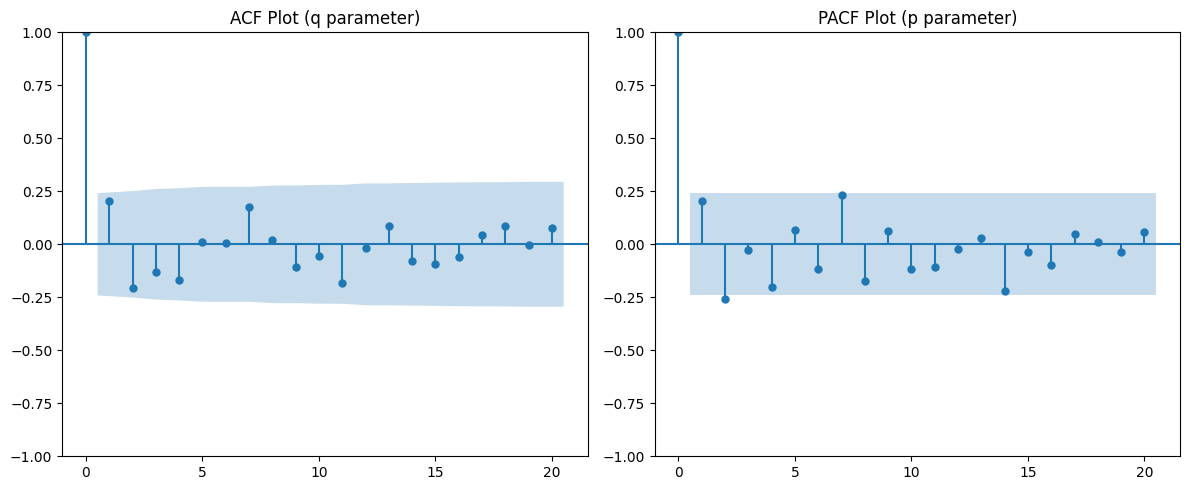

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# First-order differencing
retail_diff = retail_series.diff().dropna()

# Plot ACF and PACF
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_acf(retail_diff, lags=20, ax=plt.gca())
plt.title('ACF Plot (q parameter)')

plt.subplot(1, 2, 2)
plot_pacf(retail_diff, lags=20, ax=plt.gca(), method='ywm')
plt.title('PACF Plot (p parameter)')

plt.tight_layout()
plt.show()


# **Fit arima model**

                                 SARIMAX Results                                 
Dep. Variable:     bengaluru_retailprice   No. Observations:                   67
Model:                    ARIMA(1, 1, 1)   Log Likelihood                -451.701
Date:                   Thu, 17 Jul 2025   AIC                            909.402
Time:                           09:04:34   BIC                            915.971
Sample:                                0   HQIC                           911.998
                                    - 67                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4891      0.130     -3.766      0.000      -0.744      -0.235
ma.L1          0.9236      0.070     13.168      0.000       0.786       1.061
sigma2      5.074e+04   8160

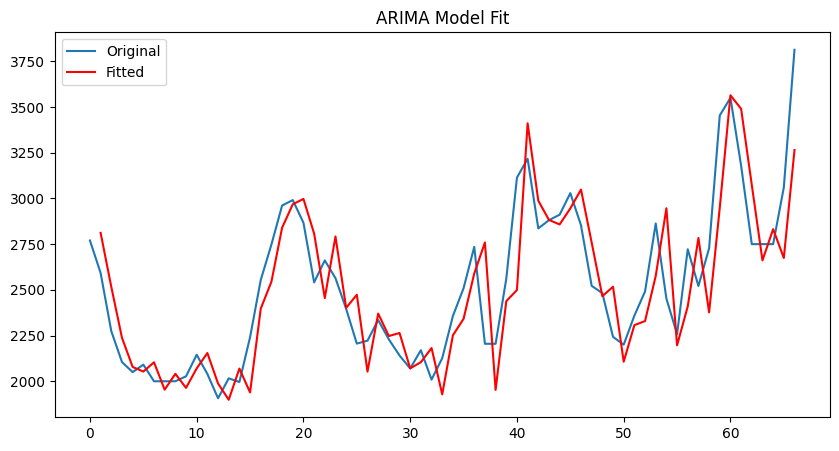

In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Load and prepare data
df = pd.read_csv("bengaluru_potato.csv")
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date')
retail_series = df['bengaluru_retailprice']

# Fit ARIMA model (example: ARIMA(1,1,1))
model = ARIMA(retail_series, order=(1, 1, 1))
fitted_model = model.fit()

# Summary
print(fitted_model.summary())

# Align index for fitted values (due to differencing)
fitted_vals = pd.Series(fitted_model.fittedvalues, index=retail_series.index[1:])

# Plot
plt.figure(figsize=(10, 5))
plt.plot(retail_series.index, retail_series, label='Original')
plt.plot(fitted_vals.index, fitted_vals, label='Fitted', color='red')
plt.legend()
plt.title('ARIMA Model Fit')
plt.show()


Based on your earlier ADF test and standard ACF/PACF interpretation:

Since we applied first-order differencing, d = 1

Suppose from typical ACF/PACF behavior:

PACF shows a sharp cutoff at lag 1 ⇒ p = 1

ACF tails off gradually ⇒ q = 1

So, we continue with ARIMA(1, 1, 1) as a good starting model.

# **Make time series predictions**

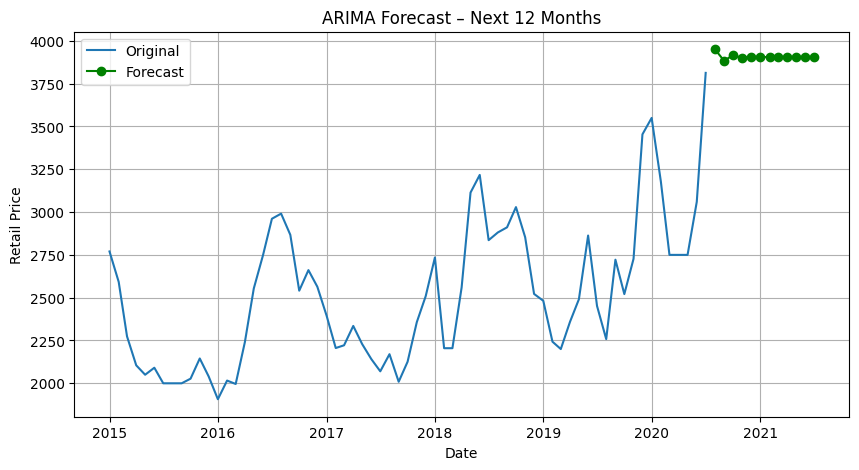

In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Load and prepare data
df = pd.read_csv("bengaluru_potato.csv")
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date')
retail_series = df['bengaluru_retailprice']

# Fit ARIMA model
model = ARIMA(retail_series, order=(1, 1, 1))
fitted_model = model.fit()

# Forecast next 12 months
forecast_steps = 12
forecast = fitted_model.forecast(steps=forecast_steps)

# Create date range for forecast
last_date = df['date'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='MS')

# Plot
plt.figure(figsize=(10, 5))
plt.plot(df['date'], retail_series, label='Original')
plt.plot(future_dates, forecast, label='Forecast', color='green', marker='o')
plt.legend()
plt.title('ARIMA Forecast – Next 12 Months')
plt.xlabel('Date')
plt.ylabel('Retail Price')
plt.grid(True)
plt.show()


# **Auto fit the arima model**

In [ ]:
!pip install pmdarima

In [ ]:
!pip install numpy==1.24.4
!pip install pmdarima==1.8.5


  Using cached pmdarima-1.8.5.tar.gz (639 kB)
  Preparing metadata (setup.py) ... done
  Using cached numpy-2.3.1-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (62 kB)
Using cached numpy-2.3.1-cp311-cp311-manylinux_2_28_x86_64.whl (16.9 MB)
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pmdarima
  Running setup.py clean for pmdarima
Failed to build pmdarima
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (pmdarima)


In [ ]:
import pandas as pd
from pmdarima import auto_arima
import matplotlib.pyplot as plt

# Load and prepare data
df = pd.read_csv("bengaluru_potato.csv")
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date')
retail_series = df['bengaluru_retailprice']

# Auto ARIMA model
auto_model = auto_arima(retail_series, seasonal=False, trace=True,
                        error_action='ignore', suppress_warnings=True, stepwise=True)

# Summary
print(auto_model.summary())

# Forecast next 12 months
forecast = auto_model.predict(n_periods=12)

# Generate future dates
future_dates = pd.date_range(start=df['date'].iloc[-1] + pd.DateOffset(months=1), periods=12, freq='MS')

# Plot
plt.figure(figsize=(10, 5))
plt.plot(df['date'], retail_series, label='Original')
plt.plot(future_dates, forecast, label='Forecast', color='green', marker='o')
plt.legend()
plt.title('Auto ARIMA Forecast – Next 12 Months')
plt.xlabel('Date')
plt.ylabel('Retail Price')
plt.grid(True)
plt.show()


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject